# Modules

In [1]:
import timm
from fastai.vision.all import *
from fastai.vision.widgets import *
import os
import matplotlib.pyplot as plt
from IPython.display import Image
os.environ["TORCH_HOME"] = "/media/hdd/Datasets/"
os.environ["FASTAI_HOME"] = "/media/hdd/Datasets/"

# Train

In [2]:
def predict_batch(self, item, rm_type_tfms=None, with_input=False):
    dl = self.dls.test_dl(item, rm_type_tfms=rm_type_tfms, num_workers=0)
    ret = self.get_preds(dl=dl, with_decoded = True)
    return ret
Learner.predict_batch = predict_batch

In [3]:
root_dir = "/media/hdd/Datasets/Fish_Dataset/Fish_Dataset/"
path = Path(root_dir)
fields = DataBlock(
    blocks=(ImageBlock, CategoryBlock),
    get_items=get_image_files,
    get_y=parent_label,
    splitter=RandomSplitter(valid_pct=0.2, seed=42),
    item_tfms=RandomResizedCrop(224, min_scale=0.5),
    batch_tfms=aug_transforms(),
)
dls = fields.dataloaders(path)
learn = vision_learner(dls, resnet18, metrics=[accuracy, error_rate]).to_fp16()


/home/eragon/micromamba/envs/pytorcher/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and will be removed in 0.15, please use 'weights' instead.
  warnings.warn(
/home/eragon/micromamba/envs/pytorcher/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and will be removed in 0.15. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [4]:

learn.fine_tune(1)

epoch,train_loss,valid_loss,accuracy,error_rate,time
0,0.798485,0.424878,0.844722,0.155278,00:30


epoch,train_loss,valid_loss,accuracy,error_rate,time
0,0.376960,0.211059,0.916944,0.083056,00:39


In [ ]:

# learn = vision_learner(dls, resnet34, metrics=[accuracy, error_rate]).to_fp16()
# learn.fine_tune(1)

In [3]:
learn.save("fish_v1_no_aug")

Path('models/fish_v1_no_aug.pth')

In [69]:
learn.load("fish_v1_no_aug")

# GradCAM

In [5]:
class Hook:
    def __init__(self, m):
        self.hook = m.register_forward_hook(self.hook_func)

    def hook_func(self, m, i, o):
        self.stored = o.detach().clone()

    def __enter__(self, *args):
        return self

    def __exit__(self, *args):
        self.hook.remove()

In [6]:
class HookBwd:
    def __init__(self, m):
        self.hook = m.register_backward_hook(self.hook_func)

    def hook_func(self, m, gi, go):
        self.stored = go[0].detach().clone()

    def __enter__(self, *args):
        return self

    def __exit__(self, *args):
        self.hook.remove()

In [7]:
dls.valid_ds[1]

(PILImage mode=RGB size=590x445, TensorCategory(6))

In [8]:
learn.predict(dls.valid_ds[1][0])

('Red Mullet',
 TensorBase(6),
 TensorBase([7.3780e-10, 1.5739e-10, 7.5382e-10, 2.2990e-10, 1.3347e-09,
             3.4507e-11, 9.9999e-01, 5.1389e-09, 7.8526e-11, 3.0457e-10,
             6.9164e-11, 4.8663e-11, 5.8277e-07, 1.4143e-07, 9.7800e-06,
             6.6113e-09, 1.6853e-10, 1.8582e-10]))

In [9]:
learn.model[-2][4][-1]

BasicBlock(
  (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
  (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
)

/home/eragon/micromamba/envs/pytorcher/lib/python3.10/site-packages/torch/nn/modules/module.py:1053: UserWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  warnings.warn("Using a non-full backward hook when the forward contains multiple autograd Nodes "


index 2 is out of range
index 3 is out of range
index 4 is out of range
index 5 is out of range
index 6 is out of range
index 7 is out of range


<Figure size 1600x800 with 0 Axes>

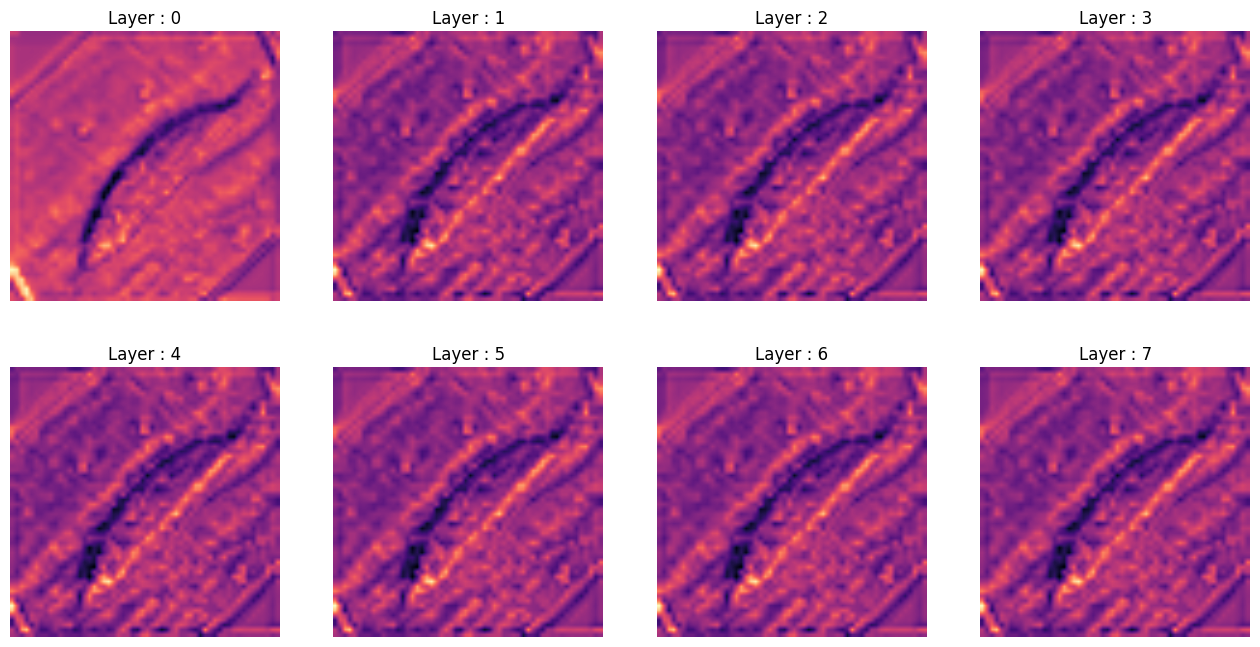

In [32]:
img = PILImage.create(
    "/media/hdd/Datasets/Fish_Dataset/Fish_Dataset/Black Sea Sprat/Black Sea Sprat/00001.png"
)

(x,) = first(dls.test_dl([img]))
# cam_map = torch.einsum('ck,kij->cij', learn.model[1][-1].weight, act)
x_dec = TensorImage(dls.train.decode((x,))[0][0])

image_count = len(learn.model[0])
col = 4
row = math.ceil(image_count / col)
plt.figure(figsize=(col * 4, row * 4))
plt.figure(figsize=(col * 4, row * 4))

for layer in range(image_count):  # no of layers
    cls = 1
    try:
        with HookBwd(learn.model[-2][4][layer]) as hookg:  # for other layers
            with Hook(learn.model[-2][4][layer]) as hook:
                output = learn.model.eval()(x.cuda())
                act = hook.stored
            output[0, cls].backward()
            grad = hookg.stored
        w = grad[0].mean(dim=[1, 2], keepdim=True)
        cam_map = (w * act[0]).sum(0)

    except Exception as e:
        print(e)

    plt.subplot(row, col, layer + 1)
    x_dec.show(ctx=plt)
    plt.imshow(
        cam_map.detach().cpu(),
        alpha=1.0,
        extent=(0, 224, 224, 0),
        interpolation="bilinear",
        cmap="magma",
    )
    plt.title(f"Layer : {layer}")
    plt.axis("off")

In [60]:
# (x,) = first(dls.test_dl([dls.train_ds[2][0]]))
img = PILImage.create(
    "/media/hdd/Datasets/Fish_Dataset/Fish_Dataset/Black Sea Sprat/Black Sea Sprat/00001.png"
)
(x,) = first(dls.test_dl([img]))


# cam_map = torch.einsum('ck,kij->cij', learn.model[1][-1].weight, act)
x_dec = TensorImage(dls.train.decode((x,))[0][0])

# image_count = len(learn.model[0])
# col = 4
# row = math.ceil(image_count / col)
# plt.figure(figsize=(col * 4, row * 4))
# plt.figure(figsize=(col * 4, row * 4))

plt.figure(figsize=(224, 224))

cls = 1
try:
    with HookBwd(learn.model[-2][4][-1]) as hookg:  # for other layers
        with Hook(learn.model[-2][4][-1]) as hook:
            output = learn.model.eval()(x.cuda())
            act = hook.stored
        output[0, cls].backward()
        grad = hookg.stored
    w = grad[0].mean(dim=[1, 2], keepdim=True)
    cam_map = (w * act[0]).sum(0)
    print(x.shape,x_dec.shape, w.shape, cam_map.shape)

except Exception as e:
    print(e)
# x_dec.show(ctx=plt)
# plt.imshow(
#     cam_map.detach().cpu(),
#     alpha=0.8,
#     extent=(0, 224, 224, 0),
#     interpolation="bilinear",
#     cmap="magma",
# )
# plt.axis("off")

torch.Size([1, 3, 224, 224]) torch.Size([3, 224, 224]) torch.Size([64, 1, 1]) torch.Size([56, 56])


<Figure size 22400x22400 with 0 Axes>

In [61]:
cam_map.shape

torch.Size([56, 56])

In [62]:
import torchvision.transforms as T

In [63]:
import PIL

In [64]:
cam_map

TensorImage([[ 0.0008,  0.0020,  0.0017,  ...,  0.0004, -0.0003,  0.0034],
             [ 0.0019,  0.0015,  0.0030,  ...,  0.0039,  0.0007,  0.0034],
             [ 0.0012,  0.0012,  0.0026,  ...,  0.0046,  0.0031,  0.0040],
             ...,
             [-0.0001,  0.0033,  0.0059,  ...,  0.0013,  0.0005,  0.0008],
             [ 0.0038,  0.0010,  0.0076,  ...,  0.0040,  0.0052,  0.0054],
             [ 0.0033,  0.0025,  0.0014,  ...,  0.0029,  0.0019,  0.0025]],
            device='cuda:0')

<module 'matplotlib.pyplot' from '/home/eragon/micromamba/envs/pytorcher/lib/python3.10/site-packages/matplotlib/pyplot.py'>

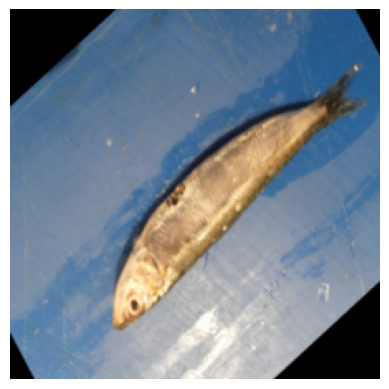

In [65]:
x_dec.show(ctx=plt)

In [66]:
cam_map.detach().cpu()

TensorImage([[ 0.0008,  0.0020,  0.0017,  ...,  0.0004, -0.0003,  0.0034],
             [ 0.0019,  0.0015,  0.0030,  ...,  0.0039,  0.0007,  0.0034],
             [ 0.0012,  0.0012,  0.0026,  ...,  0.0046,  0.0031,  0.0040],
             ...,
             [-0.0001,  0.0033,  0.0059,  ...,  0.0013,  0.0005,  0.0008],
             [ 0.0038,  0.0010,  0.0076,  ...,  0.0040,  0.0052,  0.0054],
             [ 0.0033,  0.0025,  0.0014,  ...,  0.0029,  0.0019,  0.0025]])

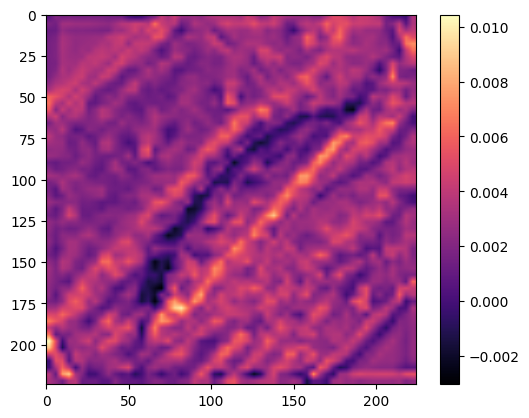

In [67]:
plt.imshow(
        cam_map.detach().cpu(),
        alpha=1,
        extent=(0, 224, 224, 0),
        interpolation="bilinear",
        cmap="magma",
    )
plt.colorbar()

In [68]:
test_cam_map = cam_map.detach().cpu()
test_im = x_dec

In [69]:
import torchvision.transforms.functional as F

t_resized = F.resize(torch.unsqueeze(test_cam_map, 0), 224)
t_resized = torch.cat([t_resized, t_resized, t_resized], dim = 0)
t_resized.shape

torch.Size([3, 224, 224])

In [70]:
test_im.shape

torch.Size([3, 224, 224])

In [71]:
test_im_back = test_im.clone()
test_im[t_resized >= 0.008] = 0.0

<AxesSubplot:>

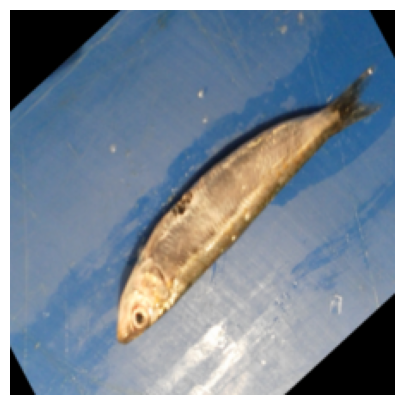

In [72]:
test_im_back.show()

<AxesSubplot:>

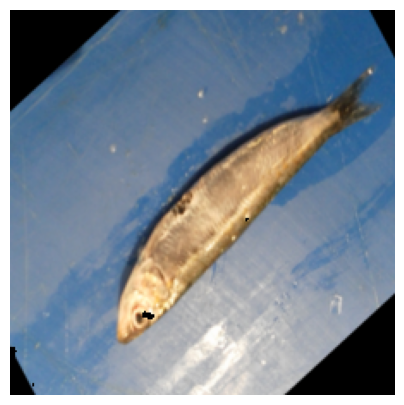

In [74]:
test_im.show()

In [75]:
old_pred_full = learn.predict(test_im_back)
new_pred_full = learn.predict(test_im)

In [76]:
old_pred_full

('Black Sea Sprat',
 TensorBase(0),
 TensorBase([9.9997e-01, 1.6070e-08, 2.5314e-06, 1.9629e-09, 2.3645e-05,
             2.8066e-08, 1.4293e-08, 3.4036e-08, 2.7569e-10, 4.7544e-08,
             6.8008e-06, 1.7154e-09, 1.9847e-07, 4.4988e-07, 1.2085e-07,
             9.7740e-10, 4.0040e-09, 1.2249e-08]))

In [77]:
new_pred_full

('Black Sea Sprat',
 TensorBase(0),
 TensorBase([9.9983e-01, 8.2560e-08, 6.1914e-06, 2.0692e-08, 1.1774e-04,
             2.5455e-07, 3.7836e-08, 2.4564e-07, 1.2188e-08, 5.1250e-07,
             2.5965e-05, 7.6868e-09, 5.6594e-06, 7.0432e-06, 1.3292e-06,
             2.7146e-08, 1.8584e-08, 1.7823e-07]))

In [78]:
old_preds, new_preds = old_pred_full[2], new_pred_full[2]

In [79]:
old_preds[old_preds.argmin()] , new_preds[new_preds.argmin()]

(TensorBase(2.7569e-10), TensorBase(7.6868e-09))

In [80]:
old_preds[old_preds.argmax()] , new_preds[new_preds.argmax()]

(TensorBase(1.0000), TensorBase(0.9998))

In [81]:
dls.train_ds

(#14400) [(PILImage mode=RGB size=590x445, TensorCategory(6)),(PILImage mode=RGB size=590x445, TensorCategory(4)),(PILImage mode=RGB size=590x445, TensorCategory(6)),(PILImage mode=RGB size=590x445, TensorCategory(11)),(PILImage mode=RGB size=590x445, TensorCategory(15)),(PILImage mode=RGB size=590x445, TensorCategory(11)),(PILImage mode=RGB size=590x445, TensorCategory(16)),(PILImage mode=RGB size=590x445, TensorCategory(15)),(PILImage mode=RGB size=590x445, TensorCategory(8)),(PILImage mode=RGB size=590x445, TensorCategory(2))...]

In [82]:
items = get_image_files(root_dir)

In [83]:
bspred = learn.predict_batch(items[:10])

In [84]:
bspred

(TensorBase([[1.5380e-11, 2.4040e-12, 9.7011e-08, 1.1829e-13, 3.0803e-13,
              9.8466e-13, 3.3305e-13, 5.9258e-13, 3.4643e-11, 1.5612e-12,
              1.9028e-08, 7.3891e-13, 4.0693e-12, 2.1942e-11, 4.5050e-11,
              1.6782e-12, 1.0000e+00, 3.1170e-12],
             [7.3863e-09, 9.2994e-10, 5.9659e-07, 1.3782e-10, 1.4958e-11,
              1.4516e-09, 4.0905e-10, 3.3516e-10, 8.2562e-09, 6.2555e-10,
              1.4090e-06, 1.8365e-10, 9.1284e-10, 1.0213e-09, 7.8680e-11,
              5.9866e-10, 1.0000e+00, 2.4000e-10],
             [1.6762e-09, 1.0322e-10, 2.3132e-08, 1.0670e-10, 5.5250e-11,
              5.3558e-10, 2.6769e-11, 3.2671e-11, 4.6728e-08, 3.2516e-10,
              1.5813e-05, 4.6253e-11, 2.8028e-09, 2.9400e-11, 2.9091e-10,
              4.7350e-11, 9.9998e-01, 5.5964e-10],
             [1.1812e-09, 1.5864e-09, 1.0427e-07, 7.4790e-10, 3.4713e-10,
              4.7779e-09, 3.7534e-10, 5.4186e-10, 4.3487e-05, 6.7183e-09,
              3.2826e-05, 4.1790e

In [85]:
learn.dls.vocab

['Black Sea Sprat', 'Black Sea Sprat GT', 'Gilt-Head Bream', 'Gilt-Head Bream GT', 'Hourse Mackerel', 'Hourse Mackerel GT', 'Red Mullet', 'Red Mullet GT', 'Red Sea Bream', 'Red Sea Bream GT', 'Sea Bass', 'Sea Bass GT', 'Shrimp', 'Shrimp GT', 'Striped Red Mullet', 'Striped Red Mullet GT', 'Trout', 'Trout GT']

## Run through and get preds for fish_dataset

In [86]:
items[0]

Path('/media/hdd/Datasets/Fish_Dataset/Fish_Dataset/Trout/Trout/00338.png')

In [87]:
vocab_dict = {learn.dls.vocab[x]:x for x in range(len(learn.dls.vocab))}

In [88]:
vocab_dict

{'Black Sea Sprat': 0,
 'Black Sea Sprat GT': 1,
 'Gilt-Head Bream': 2,
 'Gilt-Head Bream GT': 3,
 'Hourse Mackerel': 4,
 'Hourse Mackerel GT': 5,
 'Red Mullet': 6,
 'Red Mullet GT': 7,
 'Red Sea Bream': 8,
 'Red Sea Bream GT': 9,
 'Sea Bass': 10,
 'Sea Bass GT': 11,
 'Shrimp': 12,
 'Shrimp GT': 13,
 'Striped Red Mullet': 14,
 'Striped Red Mullet GT': 15,
 'Trout': 16,
 'Trout GT': 17}

In [89]:
def fish_ds_name_fn(fpath):
    return str(fpath).split("/")[-2]


In [95]:
subset = 50
ds_chosen = fish_ds_name_fn
items = get_image_files(root_dir)
# items = items.shuffle()
items = items[:subset]
bspred = learn.predict_batch(items)
item_names = list(map(lambda x: vocab_dict[x], list(map(ds_chosen, items))))


In [100]:
bspred[2]

TensorBase([16, 16, 16, 16, 16, 16, 16, 10, 16, 16, 16, 16, 16, 16, 16, 16, 16,
            16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16,
            16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16])

In [104]:
TensorBase(item_names)

TensorBase([16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16,
            16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16,
            16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16])

In [113]:
bspred[2][7]

TensorBase(10)

In [106]:
bspred[2] == TensorBase(item_names)

TensorBase([ True,  True,  True,  True,  True,  True,  True, False,  True,
             True,  True,  True,  True,  True,  True,  True,  True,  True,
             True,  True,  True,  True,  True,  True,  True,  True,  True,
             True,  True,  True,  True,  True,  True,  True,  True,  True,
             True,  True,  True,  True,  True,  True,  True,  True,  True,
             True,  True,  True,  True,  True])

In [114]:
index_wrongs = [x for x in range(subset) if bspred[2][x]!=TensorBase(item_names)[x]]
print(f"[INFO] : Pct wrong = {len(index_wrongs)/len(bspred[2])}")
index_wrongs

[INFO] : Pct wrong = 0.02


[7]

In [115]:
ds_config = {
    "fish": {
        "ds_name" :"fish",
        "name_fn" :lambda x: str(x).split("/")[-2]
    }
}

In [116]:
def rename_for_aug(fpath): 
    return fpath.parent/Path("augmented_"+fpath.name)

In [117]:
items[9], rename_for_aug(items[9])

(Path('/media/hdd/Datasets/Fish_Dataset/Fish_Dataset/Trout/Trout/00592.png'),
 Path('/media/hdd/Datasets/Fish_Dataset/Fish_Dataset/Trout/Trout/augmented_00592.png'))

In [118]:
from tqdm import tqdm

In [119]:
chosen_ds = "fish"

In [120]:
ds_meta = ds_config[chosen_ds] # replace

In [133]:
for im in tqdm(index_wrongs, total = len(index_wrongs)):
    img = PILImage.create(items[im])

    (x,) = first(dls.test_dl([img]))


    x_dec = TensorImage(dls.train.decode((x,))[0][0])

    cls = 1
    try:
        with HookBwd(learn.model[-2][4][-1]) as hookg:  # for other layers
            with Hook(learn.model[-2][4][-1]) as hook:
                output = learn.model.eval()(x.cuda())
                act = hook.stored
            output[0, cls].backward()
            grad = hookg.stored
        w = grad[0].mean(dim=[1, 2], keepdim=True)
        cam_map = (w * act[0]).sum(0)
        # print(x.shape,x_dec.shape, w.shape, cam_map.shape)

    except Exception as e:
        print(e)
    
    test_cam_map = cam_map.detach().cpu()
    t_resized = F.resize(torch.unsqueeze(test_cam_map, 0), 224)
    t_resized = torch.cat([t_resized, t_resized, t_resized], dim = 0)
    
    x_dec[t_resized >= 0.008] = 0.0

    x_dec = torch.einsum("ijk->jki", x_dec)
    print(x_dec.shape)
    plt.tight_layout()
    plt.figure(figsize=(590,445))
    plt.imshow(x_dec)
    plt.axis("off")
    plt.savefig(rename_for_aug(items[im]))

  0%|          | 0/1 [00:00<?, ?it/s]/home/eragon/micromamba/envs/pytorcher/lib/python3.10/site-packages/torch/nn/modules/module.py:1053: UserWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  warnings.warn("Using a non-full backward hook when the forward contains multiple autograd Nodes "


torch.Size([224, 224, 3])


  0%|          | 0/1 [00:51<?, ?it/s]


KeyboardInterrupt: 

In [39]:
preds, y = learn.get_preds()

In [40]:
bad_predictions = []
for i, (pred, gt_class) in enumerate(zip(preds, y)):
    pred_probability, predicted_class = torch.topk(pred, 1)
    is_correct = (predicted_class == gt_class)
    if is_correct:
        continue
    bad_predictions.append((i, predicted_class, pred_probability))

In [41]:
ds_idx, predicted_class, probability = bad_predictions[0]

In [44]:
img, label = dls.train_ds[ds_idx]

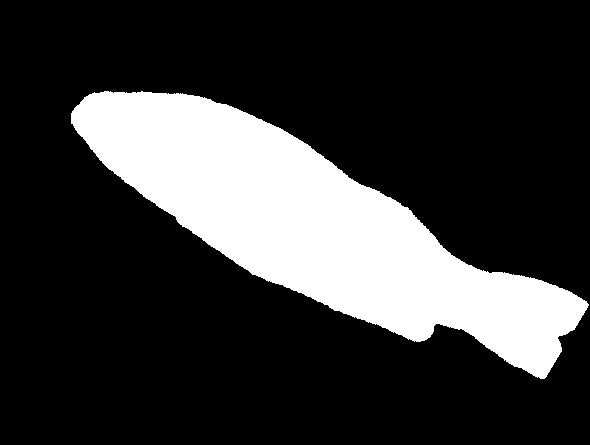

In [45]:
img

In [244]:
intp = ClassificationInterpretation.from_learner(learn)
intp.most_confused()

[('Striped Red Mullet GT', 'Red Mullet GT', 55),
 ('Gilt-Head Bream GT', 'Red Sea Bream GT', 47),
 ('Red Sea Bream GT', 'Gilt-Head Bream GT', 42),
 ('Red Mullet GT', 'Striped Red Mullet GT', 17),
 ('Sea Bass GT', 'Red Mullet GT', 10),
 ('Sea Bass GT', 'Black Sea Sprat GT', 8),
 ('Trout GT', 'Sea Bass GT', 7),
 ('Trout GT', 'Striped Red Mullet GT', 7),
 ('Sea Bass GT', 'Gilt-Head Bream GT', 6),
 ('Striped Red Mullet GT', 'Black Sea Sprat GT', 6),
 ('Red Mullet GT', 'Black Sea Sprat GT', 4),
 ('Red Sea Bream GT', 'Trout GT', 4),
 ('Shrimp GT', 'Red Mullet GT', 4),
 ('Black Sea Sprat GT', 'Striped Red Mullet GT', 3),
 ('Gilt-Head Bream GT', 'Hourse Mackerel GT', 3),
 ('Sea Bass GT', 'Striped Red Mullet GT', 3),
 ('Striped Red Mullet GT', 'Sea Bass GT', 3),
 ('Black Sea Sprat GT', 'Red Mullet GT', 2),
 ('Red Mullet GT', 'Hourse Mackerel GT', 2),
 ('Red Sea Bream GT', 'Hourse Mackerel GT', 2),
 ('Shrimp GT', 'Black Sea Sprat GT', 2),
 ('Striped Red Mullet GT', 'Hourse Mackerel GT', 2),
 ('B

NameError: name 'cam_map' is not defined

<Figure size 1600x800 with 0 Axes>

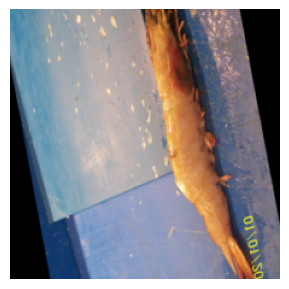

In [58]:
img = PILImage.create(
    "/media/hdd/Datasets/Fish_Dataset/Fish_Dataset/Shrimp/Shrimp/00012.png"
)
(x,) = first(dls.test_dl([img]))
# cam_map = torch.einsum('ck,kij->cij', learn.model[1][-1].weight, act)
x_dec = TensorImage(dls.train.decode((x,))[0][0])

image_count = len(learn.model[0])
col = 4
row = math.ceil(image_count / col)
plt.figure(figsize=(col * 4, row * 4))
plt.figure(figsize=(col * 4, row * 4))

for layer in range(image_count):  # no of layers
    cls = 1
    try:
        with HookBwd(learn.model[0][layer]) as hookg:  # for other layers
            with Hook(learn.model[0][layer]) as hook:
                output = learn.model.eval()(x.cuda())
                act = hook.stored
            output[0, cls].backward()
            grad = hookg.stored
        w = grad[0].mean(dim=[1, 2], keepdim=True)
        cam_map = (w * act[0]).sum(0)

    except:
        pass

    plt.subplot(row, col, layer + 1)
    x_dec.show(ctx=plt)
    plt.imshow(
        cam_map.detach().cpu(),
        alpha=0.8,
        extent=(0, 224, 224, 0),
        interpolation="bilinear",
        cmap="magma",
    )
    plt.title(f"Layer : {layer}")
    plt.axis("off")

NameError: name 'cam_map' is not defined

<Figure size 1600x800 with 0 Axes>

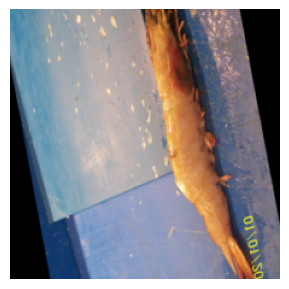

In [59]:
# ALL LAYERS CAM
img = PILImage.create(
    "/media/hdd/Datasets/Fish_Dataset/Fish_Dataset/Shrimp/Shrimp/00012.png"
)
(x,) = first(dls.test_dl([img]))
# cam_map = torch.einsum('ck,kij->cij', learn.model[1][-1].weight, act)
x_dec = TensorImage(dls.train.decode((x,))[0][0])

image_count = len(learn.model[0])
col = 4
row = math.ceil(image_count / col)
plt.figure(figsize=(col * 4, row * 4))
plt.figure(figsize=(col * 4, row * 4))

for layer in range(image_count):  # no of layers
    cls = 1
    try:
        with HookBwd(learn.model[0][layer]) as hookg:  # for other layers
            with Hook(learn.model[0][layer]) as hook:
                output = learn.model.eval()(x.cuda())
                act = hook.stored
            output[0, cls].backward()
            grad = hookg.stored
        w = grad[0].mean(dim=[1, 2], keepdim=True)
        cam_map = (w * act[0]).sum(0)

    except:
        pass

    plt.subplot(row, col, layer + 1)
    x_dec.show(ctx=plt)
    plt.imshow(
        cam_map.detach().cpu(),
        alpha=0.8,
        extent=(0, 224, 224, 0),
        interpolation="bilinear",
        cmap="magma",
    )
    plt.title(f"Layer : {layer}")
    plt.axis("off")